# Plot Figures 8-11

Analyzing clusters through time and by features

For Sawi et al., 2021

## Todo::

* Combine figure 11, features


In [1]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from obspy.signal.cross_correlation import correlate, xcorr_max


sys.path.append('.')
sys.path.append('../src/visualization/')

import paths
from sklearn.cluster import KMeans
# import figureFunctions

In [2]:


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat 
from functions2 import catMergeFromH5, swapLabels, calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2

## Define helper functions (move later)

In [3]:


# # def dateToEventID(cat):
    
# #     evID = []
    
# #     for i, dt in enumerate(cat.datetime):
        
# #         a = str(dt)    
# #         b = a.replace('-','').replace(':','').replace(' ','')[3:]
        
        
# #         evID.append(b)
        
# #     cat['event_ID'] = evID
    
# #     return cat




# # def getDailyTempDiff2(garciaDF_H,garciaDF_D,**plt_kwargs):

# #     tstart      =     plt_kwargs['tstartreal']
# #     tend        =     plt_kwargs['tendreal']

# #     garciaDF_H1 = garciaDF_H[garciaDF_H.datetime>=tstart]
# #     garciaDF_H1 = garciaDF_H1[garciaDF_H1.datetime<tend]

# #     garciaDF_D1 = garciaDF_D[garciaDF_D.datetime>=tstart]
# #     garciaDF_D1 = garciaDF_D1[garciaDF_D1.datetime<tend]


# #     temp_H = garciaDF_H1.temp_H.bfill()
# #     temp_H_a = np.array(temp_H)

# #     temp_H_a_r = temp_H_a.reshape(len(garciaDF_D1),24)
# #     mean_diff = []
# #     for i in range(len(temp_H_a_r[:,0])):
# #     #     plt.plot(temp_H_a_r[i,:] - garciaDF_D1.temp_D.iloc[i])
# #         mean_diff.append(temp_H_a_r[i,:] - garciaDF_D1.temp_D.iloc[i])


# #     mean_mean_diff = np.mean(mean_diff,axis=0)
# #     return mean_mean_diff



# def catMergeFromH5(path_Cat,path_proj,outfile_name):
#     '''
#     Keep csv catalog events based on H5 used in SpecUFEx 
    
#     '''
    
#     ## read 'raw' catalog, the immutable one
#     cat_raw = pd.read_csv(path_Cat)
#     cat_raw['event_ID'] = [str(int(evv)) for evv in cat_raw['event_ID']]    
    
    
#     ## load event IDs from H5
#     MLout =  h5py.File(path_proj + outfile_name,'r')
#     evID_kept = [evID.decode('utf-8') for evID in MLout['catalog/event_ID/'][:]]
#     MLout.close()
    
#     ## put H5 events into pandas dataframe
#     df_kept = pd.DataFrame({'event_ID':evID_kept})

#     ## merge based on event ID
#     cat00 = pd.merge(cat_raw,df_kept,on='event_ID')
    
#     ## if length of H5 events and merged catalog are equal, then success
#     if len(evID_kept) == len(cat00):
#         print(f'{len(cat00)} events kept, merge sucessful')
#     else:
#         print('check merge -- error may have occurred ')
    
    
#     ## convert to datetime, set as index
#     cat00['datetime'] = [pd.to_datetime(i) for i in cat00.datetime]
#     cat00['datetime_index']= [pd.to_datetime(i) for i in cat00.datetime]
#     cat00 = cat00.set_index('datetime_index')    


#     return cat00
        
        
        

## Set paths

In [4]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Final_v11_J8"
keyN = "BB_Gorner_Cont_Final_v10_J8"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']


path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN


pathFig = '../reports/figures/'
pathAuxData = '../data/processed/Garcia/'

## Load auxiliary data

In [5]:
## Load auxiliary catalog

gps_station_list = ['24','34','36','37']
gps_df_list = []

for gst in gps_station_list:
    
    
    gps_df = pd.read_csv(f'{pathAuxData}gps_roll{gst}.csv',index_col=0)
    gps_df['datetime'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df['datetime_index'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df = gps_df.set_index('datetime_index')
    
    
    gps_df_list.append(gps_df)


lake_df = pd.read_csv(f'{pathAuxData}lake_df.csv',index_col=0)
lake_df['datetime'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df['datetime_index'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df = lake_df.set_index('datetime_index')


meteor_df = pd.read_csv(f'{pathAuxData}meteor_df.csv',index_col=0)
meteor_df['datetime'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df['datetime_index'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df = meteor_df.set_index('datetime_index')



## Define some important times in study period

In [6]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load original catalogs

In [7]:
cat00 = catMergeFromH5(path_Cat,path_proj,outfile_name)
cat00N = catMergeFromH5(path_CatN,path_projN,outfile_nameN)

1411 events kept, merge sucessful
1521 events kept, merge sucessful


## Load station data

In [8]:
##station data 
stn = pd.read_csv("../data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
     

## Get experiment parameters from H5 file

In [9]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [10]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [11]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
#all times in UTC
hour_of_approx_max_temp = 14
hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [12]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend,     ## actual study bound
              'supraDraint':supraDraint,
              'subDraint':subDraint,
              'drainEndt':drainEndt}            


## Specs for figures JGR

In [13]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

## Reduce dimensionality

* Perform PCA on FPs 
* Calculate PVE (percent variance explained) for each PC, and keep enouch PCs to capture XX% of variance
* Cluster using Kmeans 
* Choose cluster based on highest mean silhouette score


In [14]:

PCA_df, numPCA_PVE, cum_pve = PVEofPCA(path_proj,outfile_name,cat00,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False);
PCA_dfN, numPCA_PVEN, cum_pveN = PVEofPCA(path_projN,outfile_nameN,cat00N,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False)



1 0.141772319308
2 0.225535762942
3 0.277379352821
4 0.312981183595
5 0.34350418891
6 0.372574699026
7 0.398888468951
8 0.420886941793
9 0.43935448425
10 0.456417969415
11 0.472889373829
12 0.488670647047
13 0.50351787881
14 0.517468110142
15 0.53075194847
16 0.543699703752
17 0.556259138368
18 0.568419603574
19 0.580152322118
20 0.591304965778
21 0.602288560999
22 0.612594563329
23 0.621931711607
24 0.630668252571
25 0.639965553903
26 0.648420564091
27 0.657279856687
28 0.664971010611
29 0.673384010212
30 0.680600852656
31 0.687587277811
32 0.694642084125
33 0.701945117026
34 0.709183002255
35 0.715307780943
36 0.721868698934
37 0.72785451951
38 0.735017758926
39 0.740937752332
40 0.746498561806
41 0.752903403594
42 0.758587619551
43 0.764183944531
44 0.769360779392
45 0.774594566995
46 0.779856349513
47 0.784637382358
48 0.789954150376
49 0.794400322912
50 0.799308940369
51 0.803719536981
52 0.808310588906
53 0.812726788379
54 0.816698945705
55 0.820891988396
56 0.824848532941
57 0.8

In [15]:
print(f'\n For icequakes, {100*cum_pve:.2f}% of variance explained by the first {numPCA_PVE} principal components')
print(f'\n For noise, {100*cum_pveN:.2f}% of variance explained by the first {numPCA_PVEN} principal components')


 For icequakes, 86.01% of variance explained by the first 66 principal components

 For noise, 86.09% of variance explained by the first 3 principal components


In [16]:
stand = False #standard scalar before PCA


#returns a PCA sklearn object, a dataframe of cat00 but with columns for PCs, and a numpy array of PCs (N x numPC)

sklearn_pca, cat00, Y_PCA = PCAonFP(path_proj,outfile_name,cat00,numPCA=numPCA_PVE,stand=stand)
sklearn_pcaN, cat00N, Y_PCAN = PCAonFP(path_projN,outfile_nameN,cat00N,numPCA=numPCA_PVEN,stand=stand)


## Clustering using Kmeans, validating using silhouette score

In [17]:
## silh score and validation
##making rep catalog


##can force K here
Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


cat00, catall, Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(path_proj,outfile_name,cat00,range_n_clusters_all,numPCA=numPCA_PVE,Xtype='fingerprints', distMeasure = "SilhScore",stand=stand);

print('Event optimum number of clusters:: ',Kopt)


cat00N, catallN, KoptN, maxSilScoreN, avgSilsN, sseN,cluster_labels_bestN,ss_bestN,euc_dist_bestN = calcSilhScore(path_projN,outfile_nameN,cat00N,range_n_clusters_all,numPCA=numPCA_PVEN,Xtype='fingerprints',distMeasure = "SilhScore", stand=stand);


print('Noise optimum number of clusters:: ',KoptN)


kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 3
Event optimum number of clusters::  3
kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 4
Noise optimum number of clusters::  4


### 10 most representative events

In [18]:
catRep = getTopFCat(cat00,topF=10) 

catRepN = getTopFCat(cat00N,topF=10)

# Figure 8 - Hourly clusters

In [19]:
# def getDailyTempDiff2(meteor_df,**plt_kwargs):

#     tstart      =     plt_kwargs['tstartreal']
#     tend        =     plt_kwargs['tendreal']

#     meteor_df1 = meteor_df[meteor_df.datetime>=tstart]
#     meteor_df1 = meteor_df1[meteor_df1.datetime<tend]
    
#     ##BACKFILL
#     temp_H = meteor_df1.temp.resample('H',loffset='30T').mean().ffill()
#     temp_D = meteor_df1.temp.resample('D',loffset='12H').mean().ffill()
    

#     temp_H_a = np.array(temp_H)

#     temp_H_a_r = temp_H_a.reshape(len(temp_D),24)
#     mean_diff = []
#     for i in range(len(temp_H_a_r[:,0])):
#     #     plt.plot(temp_H_a_r[i,:] - garciaDF_D1.temp_D.iloc[i])
#         mean_diff.append(temp_H_a_r[i,:] - temp_D.iloc[i])


#     mean_mean_diff = np.mean(mean_diff,axis=0)
#     return mean_mean_diff

../src/visualization/functions2.py:319: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  temp_H = meteor_df1.temp.resample('H',loffset='30T').mean().ffill()
../src/visualization/functions2.py:320: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  temp_D = meteor_df1.temp.resample('D',loffset='12H').mean().ffill()


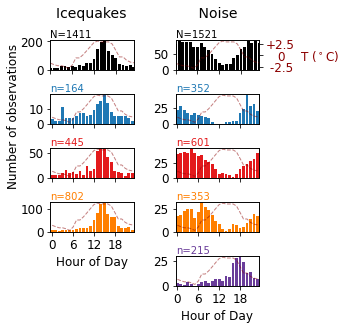

In [20]:
plt.rcParams.update({'font.size': 12})
title = 'Icequakes'
titleN = 'Noise'
dailyTempDiff = getDailyTempDiff(meteor_df,**plt_kwargs)


tfont = 14
tpad = 16

fig,axes = plt.subplots(figsize = (width1,height1))#,sharex=True)#,constrained_layout=True)

plt.suptitle('Icequakes                Noise  ',fontsize=tfont)  

gs = gridspec.GridSpec(len(catallN)+1, 2)

# gs.update(left=0.05, right=0.35, wspace=.3, hspace=1)
gs.update(wspace=.5, hspace=.8)


### ICEQUAKE PROPORTION HOURLY
ax = plt.subplot(gs[0,0])

figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=20,label='none',colorBy='all',k=0,**plt_kwargs)
ax.set_title(f'N={len(cat00)}', loc='left',fontsize=10,pad=1,color='k')
ax.set_ylabel('')
ax.set_xlim(0,23)
ax.set_xticklabels([]) 
ax.set_xlabel('')

### ICEQUAKES BY CLUSTER HOURLY

for k in range(1,Kopt+1):
    
    i = k
    
    ax = plt.subplot(gs[i,0])
    ax.set_title(f'n={len(cat00[cat00.Cluster==k])}', loc='left',fontsize=10,pad=1,color=colors[k-1])
    
#     figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,colorBy='cluster',k=k,**plt_kwargs)
    
    if k == 0:
        figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,label='right',colorBy='cluster',k=k,**plt_kwargs)
#         ax.set_title(title,fontsize=tfont,pad=tpad)  
    else:
        figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
        ax.set_ylabel('')
        
    
    if k != Kopt:        
        ax.set_xlabel('')
        ax.set_xticklabels([])  
    if k == 1:
        ax.set_ylabel('Number of observations    ',labelpad=8)
    
#     ax.set_yticklabels([])  

        
        
# ### NOISE PROPORTION HOURLY
axN = plt.subplot(gs[0,1])

figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=axN,labelpad=20,label='right',colorBy='all',k=0,**plt_kwargs)

axN.set_title(f'N={len(cat00N)}', loc='left',fontsize=10,pad=1,color='k')
axN.set_ylabel('')
axN.set_xlim(0,23)
axN.set_xticklabels([]) 
axN.set_xlabel('')

### NOISE BY CLUSTER HOURLY
for k in range(1,KoptN+1):
    
    i = k
    
    axN = plt.subplot(gs[i,1])

    axN.set_title(f'n={len(cat00N[cat00N.Cluster==k])}', loc='left', fontsize=10,pad=1,color=colors[k-1])
    if k == 0:
        figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=axN,labelpad=20,label='none',colorBy='cluster',k=k,**plt_kwargs)

    if k != 1:
        figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=axN,labelpad=10,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
        axN.set_ylabel('')
#         ax.set_yticks([])   
    else:
        figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=axN,labelpad=8,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
    if k != KoptN:
        axN.set_xticklabels([]) 

        axN.set_xlabel('')

plt.savefig(pathFig + f'Figure_8.pdf',bbox_inches='tight')


# Figure 9a -  Aux data full season

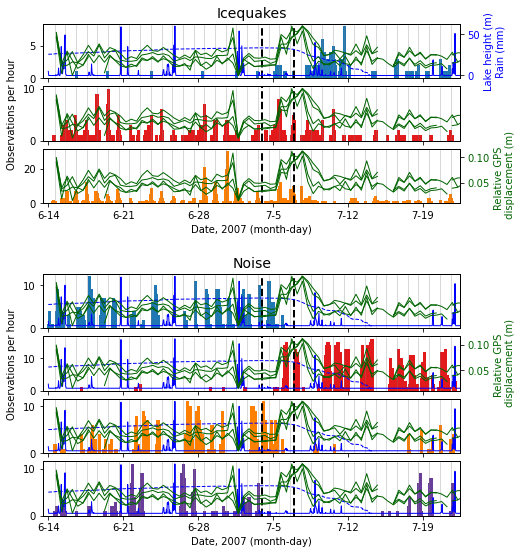

In [25]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size': 10})
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)


rain_df = meteor_df.rain


gs = gridspec.GridSpec(KoptN+Kopt+1,1)
gs.update(wspace=.6, hspace=.15)

tpad = 6


gpsstations = [24,34,36,37]

timecode = '3H'
datatype = ''


title = 'Icequakes'
textY = 16  

titleN = 'Noise'
textYN = 17.5

for k in range(1,Kopt+1):
    
    ax=plt.subplot(gs[k-1,0])
#     ax.set_ylim(0,20)
#     ax.set_ylim(ymin=0)
    figureFunctions2.plotBarCluster(cat00,k=k,barWidth=.3,timeBin='H',ax=ax,**plt_kwargs)
    if k == 1:

        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)
        ax.set_title(title,fontsize=tfont,pad=tpad)

        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
    
    elif k==2:    
        ax.set_ylabel('Observations per hour',labelpad=6)    
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
            
            
    elif k==3:
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='right',ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
    
    else:
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
        
    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,c='k',linestyle='--',linewidth=2, alpha=1)   
   

    if k == Kopt:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')

        
        
ax=plt.subplot(gs[Kopt,0])
ax.axis('off')



for k in range(1,KoptN+1):
    
    ax=plt.subplot(gs[k-1+Kopt+1,0])
#     ax.set_ylim(ymin=0)

    figureFunctions2.plotBarCluster(cat00N,k=k,barWidth=.3,ax=ax,**plt_kwargs)
    figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel=None,ax=ax,**plt_kwargs)

    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,c='k',linestyle='--',linewidth=2, alpha=1)   
    
    
    if k == 1:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_title(titleN,fontsize=tfont,pad=tpad)
        
    if k == 2:

        ax.set_ylabel('Observations per hour',labelpad=6)            
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='right',ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
    else:
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)

    if k == KoptN:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
plt.savefig(pathFig + f'Figure_9_gps.pdf',bbox_inches='tight')

# Figure 9b -  Aux data during drainage

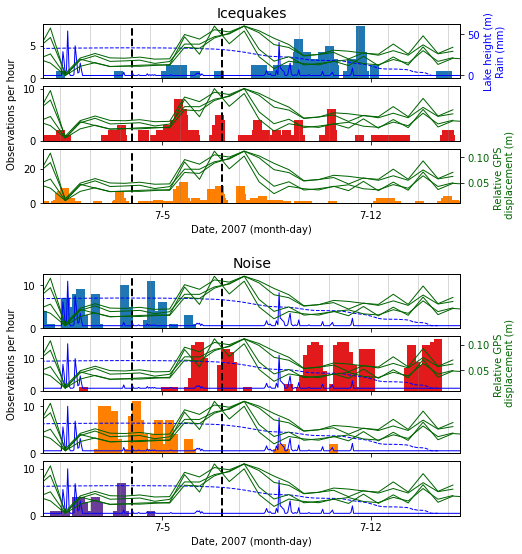

In [27]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size': 10})
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)



gs = gridspec.GridSpec(KoptN+Kopt+1,1)
gs.update(wspace=.6, hspace=.15)

tpad = 6


gpsstations = [24,34,36,37]

timecode = '3H'
datatype = ''


title = 'Icequakes'
textY = 16  

titleN = 'Noise'
textYN = 17.5


tstart2 = dtt.datetime(2007, 7, 1)
tend2 = dtt.datetime(2007, 7, 15)

for k in range(1,Kopt+1):
    
    ax=plt.subplot(gs[k-1,0])
#     ax.set_ylim(0,20)
#     ax.set_ylim(ymin=0)
    figureFunctions2.plotBarCluster(cat00,k=k,barWidth=.3,timeBin='H',ax=ax,**plt_kwargs)
    if k == 1:

        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)
        ax.set_title(title,fontsize=tfont,pad=tpad)

        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
    
    elif k==2:    
        ax.set_ylabel('Observations per hour',labelpad=6)    
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
            
            
    elif k==3:
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='right',ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
    
    else:
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
        
    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,c='k',linestyle='--',linewidth=2, alpha=1)   
   

    if k == Kopt:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')

    ax.set_xlim(tstart2,tend2)
    
    
## space between noise and icequake  
ax=plt.subplot(gs[Kopt,0])
ax.axis('off')



for k in range(1,KoptN+1):
    
    ax=plt.subplot(gs[k-1+Kopt+1,0])
#     ax.set_ylim(ymin=0)

    figureFunctions2.plotBarCluster(cat00N,k=k,barWidth=.3,ax=ax,**plt_kwargs)
    figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel=None,ax=ax,**plt_kwargs)

    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,c='k',linestyle='--',linewidth=2, alpha=1)   
    
    
    if k == 1:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_title(titleN,fontsize=tfont,pad=tpad)
        
    if k == 2:

        ax.set_ylabel('Observations per hour',labelpad=6)            
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='right',ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
                
    else:
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
            

    if k == KoptN:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
    ax.set_xlim(tstart2,tend2)
        
plt.savefig(pathFig + f'Figure_9_zoom.pdf',bbox_inches='tight')

# Figure 10 - Map of Icequakes

In [28]:
 ##v3 separate map for each cluster
##settings for yellow bars
plotMap = 0
size1 = 1000
a1 = .7

if plotMap:
    plt.rcParams.update({'font.size': 12})


    # if 'Event' in key:
    fig,axes = plt.subplots(figsize = (width2,height1))#,sharex=True,constrained_layout=True)

    
    
    gs = gridspec.GridSpec(2, 2)

    gs.update(wspace=0.02, hspace=0.07)

    #### plot map view and stations

    color_list = ['all',1,2,3,4,5]


    for k in range(0,Kopt+1):
    # for k in [0,1]:    
        ax = plt.subplot(gs[k])
        ax.set_aspect('equal')
        ax.tick_params(axis='x',labelrotation=45)

        if k == 0:
            figureFunctions2.plotMap(cat00,
                    ax=ax,
                    colorBy='cluster',
                    size=15,
                    alpha=.4,
                    **plt_kwargs); #'oneCluster''cluster';'all';'datetime'

            ax.set_xlabel('')

        else:
            figureFunctions2.plotMap(cat00,
                    ax=ax,
                    colorBy='oneCluster',
                    k=k,
                    size=15,
                    alpha=.4,
                    **plt_kwargs); #'oneCluster''cluster';'all';'datetime'

        if k%2!=0:
            ax.set_yticklabels('')
    #         ax.set_yticks([])

        if k<2:
            ax.set_xticklabels('')
#             ax.set_xticks([])
        if k==2:
            fss = 15
            ax.set_ylabel('                             Northing (m)',labelpad=30,fontsize=fss)        

        if k==2:
            ax.set_xlabel('                                       Easting (m)',labelpad=30,fontsize=fss)              


        figureFunctions2.plotStations(stn,station,ax=ax)   


    ax.tick_params(axis='x',labelrotation=45)
    
    fss = 15

    plt.savefig(pathFig + f'Figure_10.pdf',bbox_inches='tight')



# Figure 11 - Feature timelines

* Need to finesse

## Get Features

In [29]:

gF = 1
if gF:
    
    print('getting features for events...')
    df = getFeatures(cat00,filetype,fmin,fmax,fs,path_WF,nfft,dataH5_path,station,channel)
    
    print('getting features for noise...')    
    dfN = getFeatures(cat00N,filetypeN,fminN,fmaxN,fsN,path_WFN,nfftN,dataH5_pathN,station,channel)
    print('done!')
    
    # get location features


    print('getting location features for events...')    
    df_loc = getLocationFeatures(cat00,stn,station)

getting features for events...


/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2001
  n_fft, y.shape[-1]


getting features for noise...
done!
getting location features for events...


## Location Feature

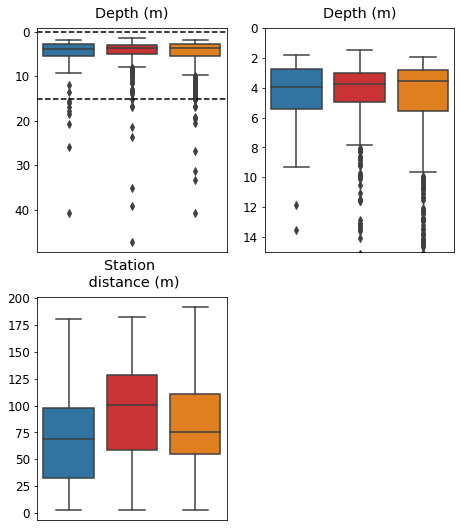

In [31]:

# ### ### ### ### ### ### ### ### ### ### ### ### 
# ### ### ### ### ### ### ### ### ### ### ### ### 
# ####### LOCATION LOCATION LOCATION
# ### ### ### ### ### ### ### ### ### ### ### ### 
# ### ### ### ### ### ### ### ### ### ### ### ### 

plt.rcParams.update({'font.size': 12})

fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(2, 2)

gs.update(wspace=0.2,hspace=0.2)

## plot Depth boxplot
maxDepth = 15
ax = plt.subplot(gs[0,0])
ax.invert_yaxis()
# ax.set_ylim(20,0)

figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'Depth_m',ax=ax,**plt_kwargs)

#lines for depth limits
ax.axhline(0,color='k',ls='--')
ax.axhline(maxDepth,color='k',ls='--')


ax.set_ylabel('')
ax.set_title('Depth (m)',pad=10)
ax.set_xticks([])
ax.set_xticklabels('')
ax.set_xlabel('')
# ax.grid('off')



## plot Depth boxplot
ax = plt.subplot(gs[0,1])
ax.invert_yaxis()
ax.set_ylim(maxDepth,0)

figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'Depth_m',ax=ax,**plt_kwargs)
ax.set_ylabel('')
ax.set_title('Depth (m)',pad=10)
ax.set_xticks([])
ax.set_xticklabels('')
ax.set_xlabel('')
# ax.grid('off')

## plot 3D dist boxplot
ax = plt.subplot(gs[1,0])
figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'DistXYZ_m',ax=ax,**plt_kwargs)
ax.set_ylabel('')
ax.set_title('Station \n distance (m)',pad=10)
# ax.set_xlabel('Cluster',labelpad=4,fontsize=FS)
# ax.grid('off')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_xticklabels('')

plt.savefig(pathFig + f'Figure_11_locationBox.pdf',bbox_inches='tight')


## Features for noise and IQs

## Resampleing by day, with a left offset of 12 H, so that the lebel calls in teh midpoint 


from pandas.tseries.frequencies import to_offset

loffset = '19min'

ts_out = ts.resample('17min').sum()

ts_out.index = ts_out.index + to_offset(loffset)

ts_out

# Figure 11 - rolling timeline of features

## Many options for binning

To get center binning, you can either choose origin={pandas.datetime of starttime or endtime}, or loffset='12H' ('12H' if binning by day; depreciated)

They bin slightly differently, but not much, so I choose the one that looks a bit smoother, the loffset='12H'

Origin=tstart same as roffset='12H'

Has point for first day, set at day 0, not great


use loffset

Origin='start_day' sets labels slightly earlier, not sure why





```
### Some code to test time lag from resampling

tstart = plt_kwargs['tstart']
tend = plt_kwargs['tend']

winSize='D'
lss='-'
mss=10
df.SC.resample(winSize,closed='left',label='left', origin=tstart).mean().plot(ax=plt.gca(),linestyle=lss,lw=1,marker='x',ms=mss+5,color='k',alpha=.8,label='Origin=tstart')
# df.SC.resample(winSize,closed='left',label='left', origin=tend).mean().plot(ax=plt.gca(),linestyle=lss,lw=1,marker='o',ms=mss,color='r',alpha=.8)

df.SC.resample(winSize,closed='left',label='left', offset='12H').mean().plot(ax=plt.gca(),linestyle=lss,lw=1,marker='o',ms=mss,color='b',alpha=.8,label='Offset=12H')

df.SC.resample(winSize,closed='left',label='left', loffset='12H').mean().plot(ax=plt.gca(),linestyle=lss,lw=1,marker='o',ms=mss,color='r',alpha=.8,label='Loffset=12H')


# df.SC.resample(winSize,closed='left',label='left', origin='start_day').mean().plot(ax=plt.gca(),linestyle=lss,lw=1,marker='o',ms=mss,color='b',alpha=.8)
plt.legend()
```

### Todo :: fix this

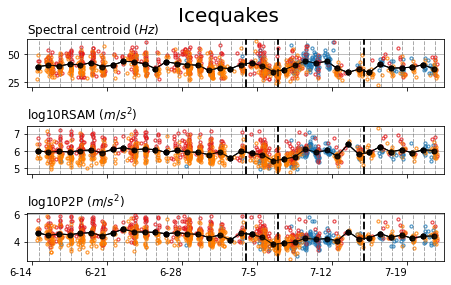

<Figure size 432x288 with 0 Axes>

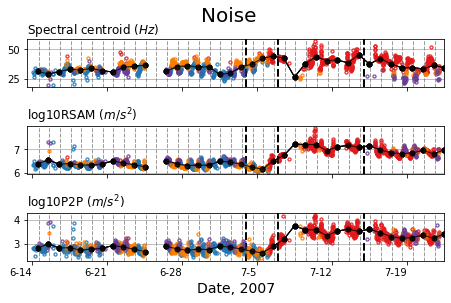

In [52]:
plt.rcParams.update({'font.size': 10})

winSize = 'D'
figureFunctions2.plotFeaturesRolling(df,
                                     winSize,
                                     Kopt,
                                     width2,
                                     height1,
                                     title='Icequakes',
                                     **plt_kwargs);

plt.savefig(pathFig + 'Figure_11_Icequakes.pdf');
ax=plt.gca();
ax.set_xlabel('');

plt.figure()
figureFunctions2.plotFeaturesRolling(dfN,
                                     winSize,
                                     KoptN,
                                     width2,
                                     height1,
                                     title='Noise',
                                     **plt_kwargs);


plt.savefig(pathFig + 'Figure_11_Noise.pdf');

# Figure 

In [ ]:



## move to analysis
# clus_sel = [1,2,3]
# sel_state = [12,14,8]

# clus_selN = [1,2,3,4]
# sel_stateN = [6,3,5,4]

# leg = ['During/after flood','Before flood','PM']
# legN = ['During/after flood','Before flood','Rain?','PM']

# ## move to clustering
# mode = 'fingerprints'#'kernalPCA'#'fingerprints'#'PCA' 

# print(key,mode,Kopt, ' clusters')
